In [3]:
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install torch


     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     --------------------------------------- 0.8/172.3 MB 24.1 MB/s eta 0:00:08
     --------------------------------------- 1.6/172.3 MB 20.5 MB/s eta 0:00:09
      -------------------------------------- 2.7/172.3 MB 21.9 MB/s eta 0:00:08
      -------------------------------------- 4.4/172.3 MB 25.5 MB/s eta 0:00:07
     - ------------------------------------- 6.7/172.3 MB 30.6 MB/s eta 0:00:06
     -- ------------------------------------ 9.6/172.3 MB 36.2 MB/s eta 0:00:05
     --- ---------------------------------- 13.7/172.3 MB 65.6 MB/s eta 0:00:03
     --- ---------------------------------- 17.7/172.3 MB 81.8 MB/s eta 0:00:02
     ---- --------------------------------- 20.7/172.3 MB 81.8 MB/s eta 0:00:02
     ----- -------------------------------- 24.4/172.3 MB 81.8 MB/s eta 0:00:02
     ------ ------------------------------- 28.1/172.3 MB 81.8 MB/s eta 0:00:02
     ------ ------------------------------- 31.

In [2]:
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

In [24]:
dataset = pd.read_csv('Data/all_data.csv')

#subtract the columns L_0_x, L_0_y, L_0_z from all the columns
for i in range(0, 21):
    dataset[f'L_{i}_x'] = dataset[f'L_{i}_x'] - dataset['L_0_x']
    dataset[f'L_{i}_y'] = dataset[f'L_{i}_y'] - dataset['L_0_y']
    # dataset[f'L_{i}_z'] = dataset[f'L_{i}_z'] - dataset['L_0_z']
    dataset[f'R_{i}_x'] = dataset[f'R_{i}_x'] - dataset['R_0_x']
    dataset[f'R_{i}_y'] = dataset[f'R_{i}_y'] - dataset['R_0_y']
    # dataset[f'R_{i}_z'] = dataset[f'R_{i}_z'] - dataset['R_0_z']

#write datatset to csv
dataset.to_csv('Data/relative_data.csv', index=False)

X = dataset.iloc[:, 1:]
Y = dataset.iloc[:, 0]

# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

print(X_train)
print(Y_train)


      L_0_x  L_0_y         L_0_z     L_1_x     L_1_y     L_1_z     L_2_x  \
2210    0.0    0.0  2.601997e-07  0.395352  0.701411 -0.017366  0.435925   
2237    0.0    0.0  3.053349e-07  0.353979  0.753209 -0.020879  0.394700   
274     0.0    0.0 -8.852496e-09  0.272827  0.336874 -0.021973  0.308031   
2719    0.0    0.0 -6.079014e-08  0.770980  0.509905  0.008528  0.774066   
1601    0.0    0.0  5.289018e-07  0.301013  0.782851 -0.036580  0.344438   
...     ...    ...           ...       ...       ...       ...       ...   
2425    0.0    0.0  2.397001e-07  0.341769  0.586572 -0.008676  0.382196   
2281    0.0    0.0  3.167342e-07  0.365406  0.712540 -0.020988  0.407784   
2005    0.0    0.0  2.290097e-07  0.370817  0.667915 -0.020639  0.397796   
688     0.0    0.0 -2.138803e-07  0.148257  0.851144 -0.030661  0.112751   
2571    0.0    0.0 -5.387773e-07  0.279720  0.592842  0.008273  0.273154   

         L_2_y     L_2_z     L_3_x  ...    R_17_z    R_18_x    R_18_y  \
2210  0.652870

In [25]:
X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
Y_train_tensor = torch.tensor(Y_train.values).long()
Y_test_tensor = torch.tensor(Y_test.values).long()

In [26]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)


torch.Size([2364, 126])
torch.Size([2364])


In [27]:
batch_size = 64
n_iters = 15000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
test = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [28]:
class GestureFNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GestureFNN, self).__init__()
        # Linear function 1: 126 --> 84
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)

        # Non-linearity 1
        self.sigmoid = torch.nn.Sigmoid()

        # Linear function 2: 84 --> 3
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)

        # Non-linearity 1
        out = self.sigmoid(out)

        # Linear function 2 (readout)
        out = self.fc2(out)
        return out



In [29]:
model = GestureFNN(input_dim=126, hidden_dim=84, output_dim=3)

critereon = torch.nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [30]:
iter = 0
for epoch in range(num_epochs):
    for i, (landmarks, labels) in enumerate(train_loader):

        lanmarks = landmarks.view(-1, 126).requires_grad_()

        optimizer.zero_grad()

        outputs = model(landmarks)

        loss = critereon(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for landmarks, labels in test_loader:
                landmarks = landmarks.view(-1, 126).requires_grad_()

                outputs = model(landmarks)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.33198851346969604. Accuracy: 85.8108139038086
Iteration: 1000. Loss: 0.23569361865520477. Accuracy: 98.14189147949219
Iteration: 1500. Loss: 0.14624656736850739. Accuracy: 97.8040542602539
Iteration: 2000. Loss: 0.15253029763698578. Accuracy: 98.14189147949219
Iteration: 2500. Loss: 0.06223447248339653. Accuracy: 98.3108139038086
Iteration: 3000. Loss: 0.09196903556585312. Accuracy: 98.64865112304688
Iteration: 3500. Loss: 0.048730332404375076. Accuracy: 98.64865112304688
Iteration: 4000. Loss: 0.07828641682863235. Accuracy: 98.64865112304688
Iteration: 4500. Loss: 0.08952944725751877. Accuracy: 98.81756591796875
Iteration: 5000. Loss: 0.06093304604291916. Accuracy: 98.98648834228516
Iteration: 5500. Loss: 0.08974248170852661. Accuracy: 98.98648834228516
Iteration: 6000. Loss: 0.027593621984124184. Accuracy: 98.98648834228516
Iteration: 6500. Loss: 0.0578569732606411. Accuracy: 98.98648834228516
Iteration: 7000. Loss: 0.03289419412612915. Accuracy: 98.9864883422

In [31]:
# test the model on the test set
correct = 0
total = 0
for landmarks, labels in test_loader:
    landmarks = landmarks.view(-1, 126).requires_grad_()

    outputs = model(landmarks)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)

    correct += (predicted == labels).sum()

accuracy = 100 * correct / total

print('Accuracy of the model on the test set: {}'.format(accuracy))


Accuracy of the model on the test set: 99.15540313720703


In [33]:
import sys
!{sys.executable} -m pip install seaborn

     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     -------------------------------------  286.7/293.3 kB 8.9 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 6.0 MB/s eta 0:00:00


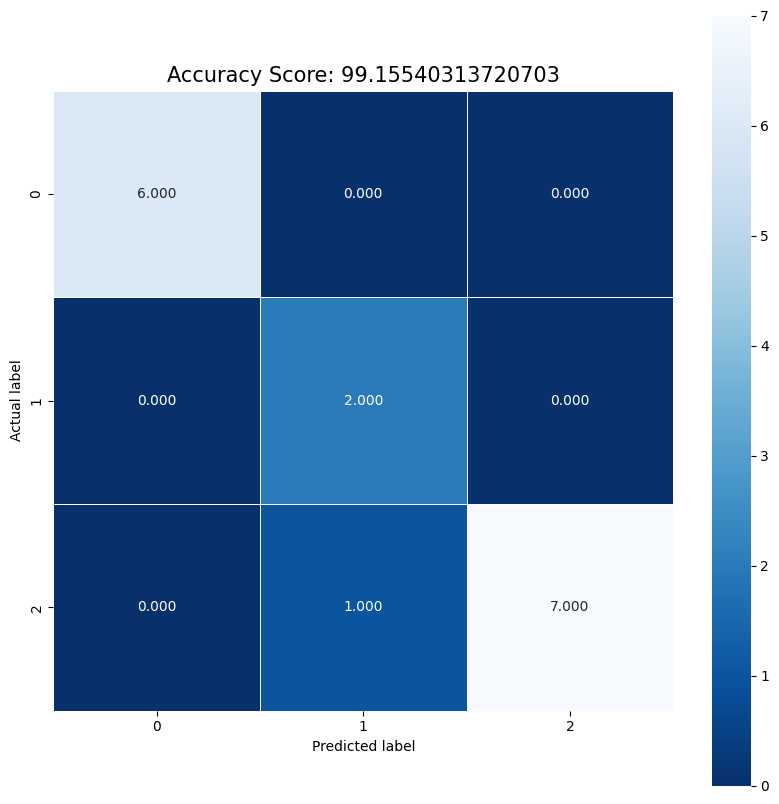

In [34]:
# plot a graphical confusion matrix for the test set using matplotlib
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predicted)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size=15)
plt.show()

